In [1]:
%pylab inline
import emcee
import programas as pg
import h5py
import MAS_library as MASL
import smoothing_library as SL

Populating the interactive namespace from numpy and matplotlib


# Voy a fitear el modelo en funcion del suavizado

In [2]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F0, F1, F2, F3, F4, C_inv):
    b1, b2, b3, b4 = params
    model = F0 + b1 * F1 + b2 * F2 + b3 * F3 +b4*F4 - 1
    diff = F_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b3, b4 = params
    if -20 < b1 < 20 and -20 < b2 < 20 and -50 < b3 < 50 and -50 < b4 < 50:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F0, F1, F2, F3, F4, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F0, F1, F2, F3, F4, C_inv)

def covariance_mat(pmean, pall):
    
    njack  = pall.shape[0]
    nbines = pall.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [7]:
def cadena_fit(smooth, rmin, nsteps = 10000, path = '/home/arodriguez/BACCO/bias-voids/IATE/perfiles/4f/'):

    damping_scale = 0.75
    
    f0_file = np.load(path+'perfilesz_F0z_'+str(smooth)+'_radio_16_100bines_30.npy')
    f1_file = np.load(path+'perfilesz_F1z_'+str(smooth)+'_radio_16_100bines_30.npy')
    f2_file = np.load(path+'perfilesz_F2z_'+str(smooth)+'_radio_16_100bines_30.npy')
    f3_file = np.load(path+'perfilesz_F3z_'+str(smooth)+'_radio_16_100bines_30.npy')
    f4_file = np.load(path+'perfilesz_F4z_'+str(smooth)+'_radio_16_100bines_30.npy')
    
    seleccion_rad, = np.where(f0_file[:,0] >= rmin)
    print('cantidad en:', rmin, 'es:', len(seleccion_rad))
    f0 = f0_file[seleccion_rad,1:]
    f1 = f1_file[seleccion_rad,1:]
    f2 = f2_file[seleccion_rad,1:]
    f3 = f3_file[seleccion_rad,1:]
    f4 = f4_file[seleccion_rad,1:]
    
    realizaciones = 80
    
    mean_0, error_0 = pg.perfil_jack(f0,realizaciones)
    mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
    mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
    mean_3, error_3 = pg.perfil_jack(f3,realizaciones)
    mean_4, error_4 = pg.perfil_jack(f4,realizaciones)
    
    original = np.load(path+'perfilesz_simulationz_smooth_'+str(smooth)+'_radio_16_100bines_30.npy')
    obs = original[seleccion_rad,1:]
    
    mean_obs, error_obs, all_obs = perfil_jack(obs,realizaciones)
    
    C = covariance_mat(mean_obs,all_obs)
    
    num_bines = mean_obs.shape[0]
    njack = realizaciones
    factor_h = 1 - (num_bines+1)/(njack-1)
    
    F_obs = mean_obs
    F0 = mean_0
    F1 = mean_1
    F2 = mean_2
    F3 = mean_3
    F4 = mean_4


    C_inv = factor_h*np.linalg.inv(C)


    # Configuración de MCMC
    ndim = 4  # Número de parámetros
    nwalkers = 50  # Número de walkers
      # Número de pasos
    
    # Inicializar walkers aleatoriamente
    starting_guesses = np.random.rand(nwalkers, ndim)
    
    # Ejecutar MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F0, F1, F2, F3, F4, C_inv))
    _ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
    
    # Análisis de resultados
    samples = sampler.get_chain(discard=500, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
    b1_samples, b2_samples, b3_samples, b4_samples = samples[:, 0], samples[:, 1], samples[:,2], samples[:,3]
    
    return b1_samples, b2_samples, b3_samples, b4_samples

In [4]:
# jens parameter: 
#b1_jens = 1.133331    
#b2_jens = 0.54724399 
#b3_jens = -0.37554869 
#b4_jens = -1.18640415

In [5]:
b1_samples, b2_samples, b3_samples, b4_samples = cadena_fit(0,16, nsteps = 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 346.39it/s]


In [6]:
dist = np.linspace(0,3,30)

b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b3_mean, b3_std = np.mean(b3_samples), np.std(b3_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

BACCO: 2.990087287191605 12.058335281784393 34.646558512950165


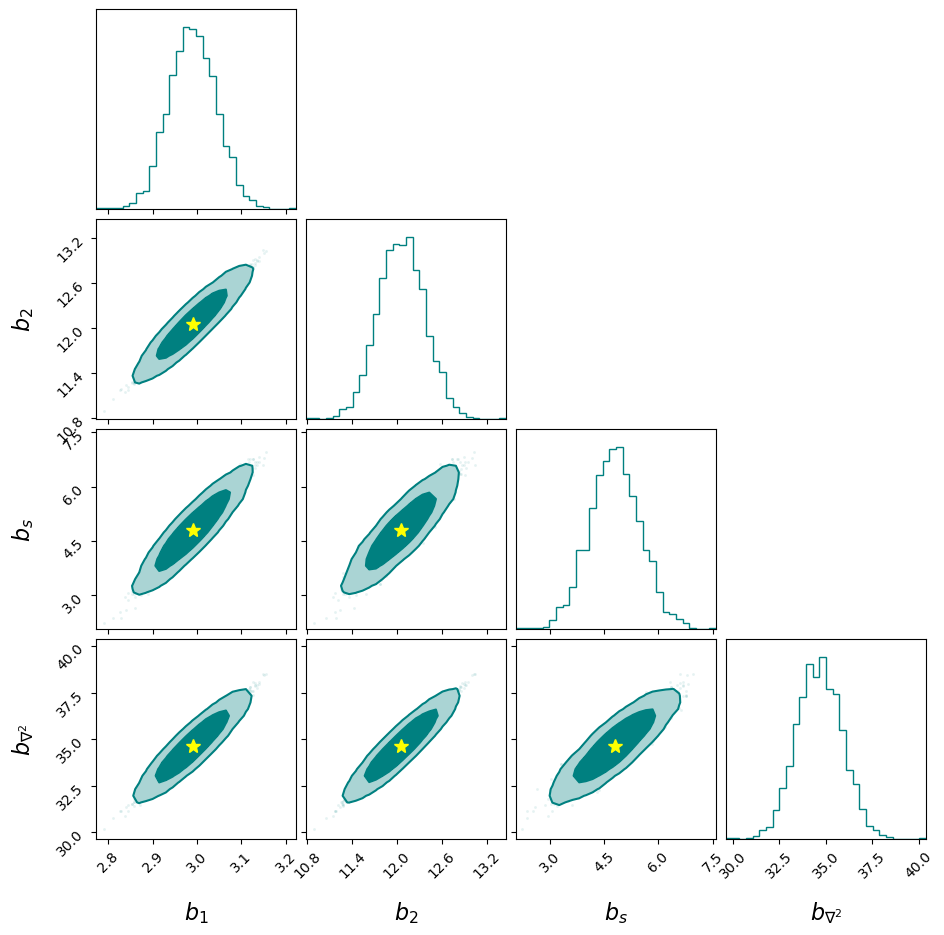

In [7]:
import corner
import random


#seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)
# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples, b2_samples, b3_samples, b4_samples]).T,
                       labels=["$ b_1 $", "$b_2$", "$b_s$","$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
axes[4].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
axes[8].plot(b1_mean, b3_mean, marker='*', color='yellow', markersize=10)
axes[9].plot(b2_mean, b3_mean, marker='*', color='yellow', markersize=10)

axes[12].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
axes[13].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)
axes[14].plot(b3_mean, b4_mean, marker='*', color='yellow', markersize=10)

print('BACCO:',b1_mean, b2_mean, b4_mean)

In [20]:
suavizados = [0,3,6,9,12]
radios = [16,17,18,19,20]
b1 = np.zeros([len(suavizados),len(radios)])
b2 = np.zeros([len(suavizados),len(radios)])
b3 = np.zeros([len(suavizados),len(radios)])
b4 = np.zeros([len(suavizados),len(radios)])
b1_e = np.zeros([len(suavizados),len(radios)])
b2_e = np.zeros([len(suavizados),len(radios)])
b3_e = np.zeros([len(suavizados),len(radios)])
b4_e = np.zeros([len(suavizados),len(radios)])

i = 0
for R in suavizados:
    j = 0
    for radio in radios:
        b1_samples, b2_samples, b3_samples, b4_samples = cadena_fit(R,radio, nsteps = 10000)
    
        b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
        b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
        b3_mean, b3_std = np.mean(b3_samples), np.std(b3_samples)
        b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)
        
        b1[i,j] = b1_mean
        b2[i,j] = b2_mean
        b3[i,j] = b3_mean
        b4[i,j] = b4_mean
        
        b1_e[i,j] = b1_std
        b2_e[i,j] = b2_std
        b3_e[i,j] = b3_std
        b4_e[i,j] = b4_std
        
        j += 1
    
    i += 1

cantidad en: 16 es: 10873


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.23it/s]


cantidad en: 17 es: 8856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.73it/s]


cantidad en: 18 es: 6991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.77it/s]


cantidad en: 19 es: 5399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.81it/s]


cantidad en: 20 es: 4200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 507.76it/s]


cantidad en: 16 es: 7534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.76it/s]


cantidad en: 17 es: 5798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.03it/s]


cantidad en: 18 es: 4557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.54it/s]


cantidad en: 19 es: 3524


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.15it/s]


cantidad en: 20 es: 2672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 673.67it/s]


cantidad en: 16 es: 4312


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 681.33it/s]


cantidad en: 17 es: 3123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 645.97it/s]


cantidad en: 18 es: 2339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 635.21it/s]


cantidad en: 19 es: 1724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 603.10it/s]


cantidad en: 20 es: 1272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 473.86it/s]


cantidad en: 16 es: 2454


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.16it/s]


cantidad en: 17 es: 1768


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.39it/s]


cantidad en: 18 es: 1324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.33it/s]


cantidad en: 19 es: 961


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 300.88it/s]


cantidad en: 20 es: 693


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.09it/s]


cantidad en: 16 es: 1250


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 301.19it/s]


cantidad en: 17 es: 892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.28it/s]


cantidad en: 18 es: 669


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.37it/s]


cantidad en: 19 es: 459


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.25it/s]


cantidad en: 20 es: 323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.11it/s]


In [14]:
b1.shape

(5, 3)

In [21]:
plt.errorbar(suavizados,b1[:,0],b1_e[:,0],label='$b_1$',marker='D')
plt.errorbar(suavizados,b2[:,0],b2_e[:,0],label='$b_2$',marker='s')
plt.errorbar(suavizados,b3[:,0],b3_e[:,0],label='$b_3$',marker='p')
plt.errorbar(suavizados,b4[:,0],b4_e[:,0],label='$b_{\\nabla^2}$',marker='o')
plt.legend(fontsize=15)
plt.xlabel('$R_{smooth}\,[Mpc/h]$',size=15)
plt.ylabel('$value$',size=15)

Text(0, 0.5, '$value$')

In [31]:
alphas = [.5,.6,.7,.8,.9]

for i in range(len(radios)):
    plt.errorbar(suavizados,b1[:,i],b1_e[:,i],label='$b_1$',marker='D',color='red',alpha=alphas[i],lw=4)
    plt.errorbar(suavizados,b2[:,i],b2_e[:,i],label='$b_2$',marker='s',color='blue',alpha=alphas[i],lw=4)
    plt.errorbar(suavizados,b3[:,i],b3_e[:,i],label='$b_3$',marker='p',color='green',alpha=alphas[i],lw=4)
    plt.errorbar(suavizados,b4[:,i],b4_e[:,i],label='$b_{\\nabla^2}$',marker='o',color='black',alpha=alphas[i],lw=4)
    
#plt.legend(fontsize=15)
plt.xlabel('$R_{smooth}\,[Mpc/h]$',size=15)
plt.ylabel('$value$',size=15)

Text(0, 0.5, '$value$')

Text(0, 0.5, '$value$')

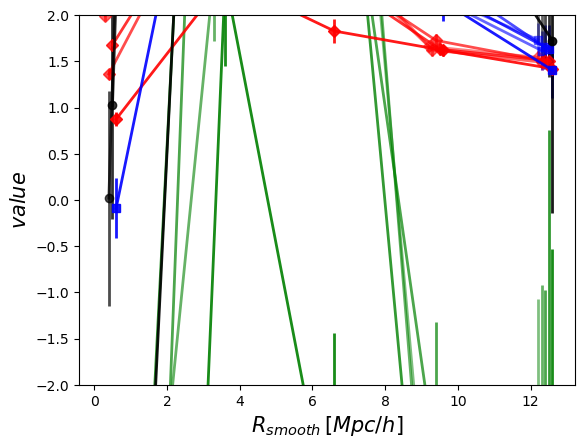

In [33]:
alphas = [.5,.6,.7,.8,.9]

for i in range(len(radios)):
    plt.errorbar(np.array(suavizados)+alphas[i]-.3,b1[:,i],b1_e[:,i],label='$b_1$',marker='D',color='red',alpha=alphas[i],lw=2)
    plt.errorbar(np.array(suavizados)+alphas[i]-.3,b2[:,i],b2_e[:,i],label='$b_2$',marker='s',color='blue',alpha=alphas[i],lw=2)
    plt.errorbar(np.array(suavizados)+alphas[i]-.3,b3[:,i],b3_e[:,i],label='$b_3$',marker='p',color='green',alpha=alphas[i],lw=2)
    plt.errorbar(np.array(suavizados)+alphas[i]-.3,b4[:,i],b4_e[:,i],label='$b_{\\nabla^2}$',marker='o',color='black',alpha=alphas[i],lw=2)
    
#plt.legend(fontsize=15)
plt.ylim(-2,2)
plt.xlabel('$R_{smooth}\,[Mpc/h]$',size=15)
plt.ylabel('$value$',size=15)

In [ ]:
b1_jens = 1.133331    
b2_jens = 0.54724399 
b3_jens = -0.37554869 
b4_jens = -1.18640415

In [25]:
stop

NameError: name 'stop' is not defined

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:47<00:00, 930.06it/s]


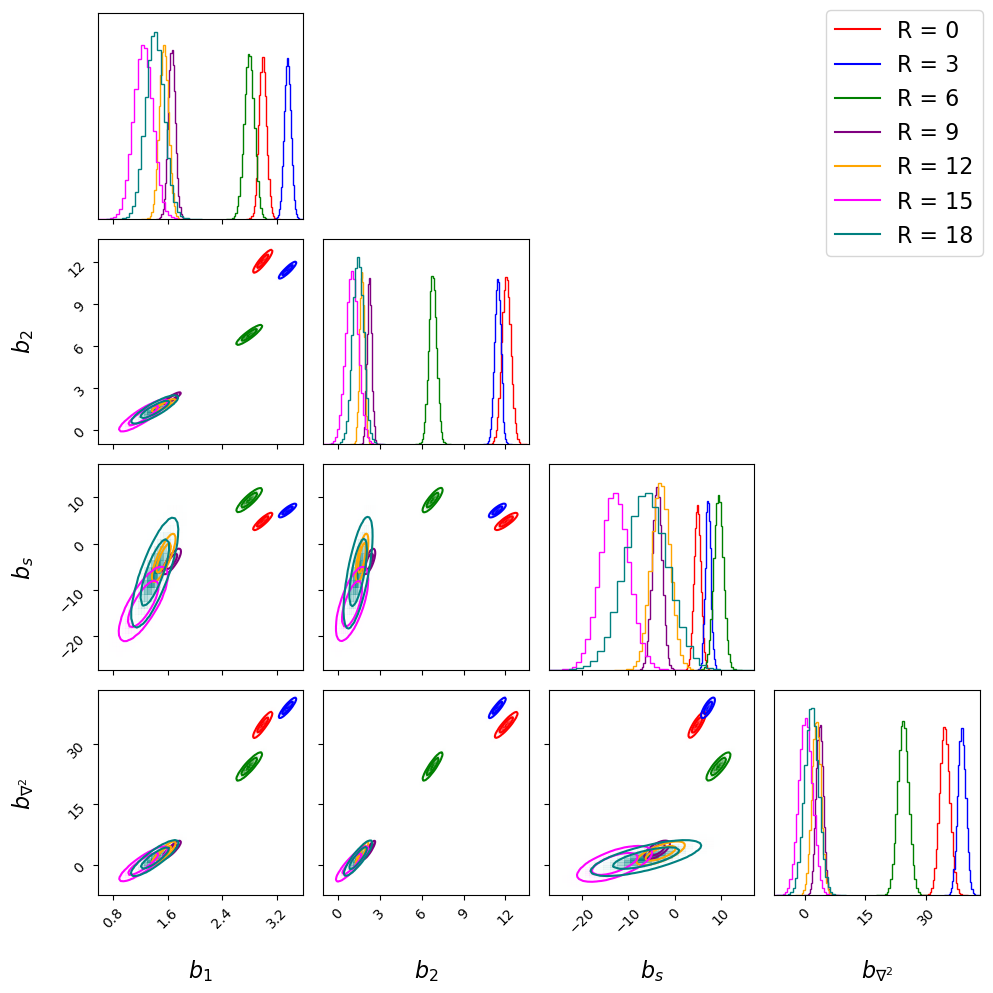

In [12]:
suavizados = [0,3,6,9,12,15,18]
nsteps = 100000

b1 = []
b2 = []
b3 = []
b4 = []
b1_e = []
b2_e = []
b3_e = []
b4_e = []



# Crear la figura y los ejes antes del bucle
fig, axarr = plt.subplots(4, 4, figsize=(10, 10))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'magenta', 'teal']#, 'brown']  # Colores para cada suavizado

# Diccionario para almacenar los handles de las leyendas
handles = []

for i, R in enumerate(suavizados):
    # Obtener las muestras de la cadena de Markov
    b1_samples, b2_samples, b3_samples, b4_samples = cadena_fit(R, 16, nsteps = nsteps)
    
    # Calcular la media y la desviación estándar de las muestras
    b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
    b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
    b3_mean, b3_std = np.mean(b3_samples), np.std(b3_samples)
    b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)
    
    # Agregar los resultados a las listas
    b1.append(b1_mean)
    b2.append(b2_mean)
    b3.append(b3_mean)
    b4.append(b4_mean)
    
    b1_e.append(b1_std)
    b2_e.append(b2_std)
    b3_e.append(b3_std)
    b4_e.append(b4_std)
    
    # Generar el gráfico de contornos con un color específico
    corner_plot = corner.corner(np.vstack([b1_samples, b2_samples, b3_samples, b4_samples]).T,
                                labels=["$b_1$", "$b_2$", "$b_s$","$b_{\\nabla^2}$"],
                                bins=30, smooth=1.0, plot_datapoints=False,
                                plot_contours=True, fill_contours=False,
                                levels=[0.68, 0.95],
                                label_kwargs={"fontsize": 16},
                                color=colors[i],
                                fig=fig)
    
    # Crear un handle para la leyenda
    handles.append(plt.Line2D([], [], color=colors[i], label=f'R = {R}'))

# Agregar la leyenda al gráfico
fig.legend(handles=handles, loc='upper right', fontsize=16)

# Ajustar los espacios entre subplots
plt.tight_layout()

Text(0, 0.5, '$value$')

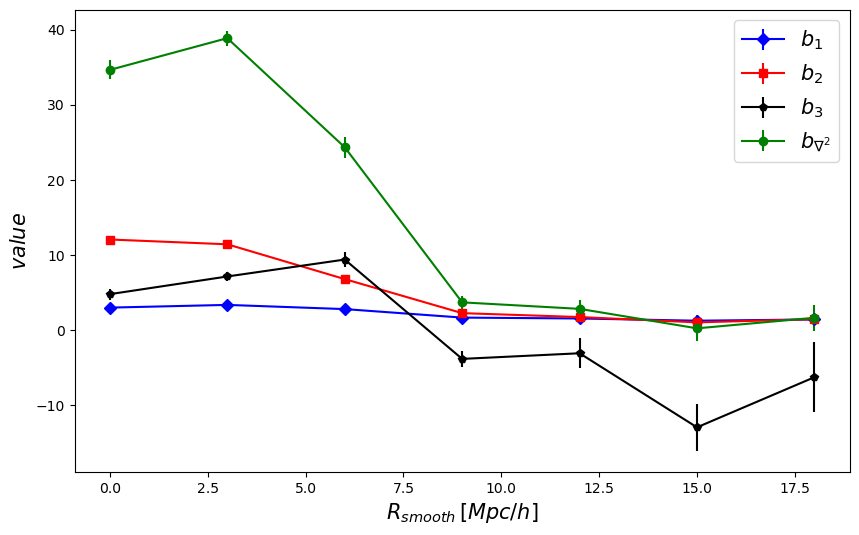

In [11]:
# Crear una nueva figura para las barras de error
plt.figure(figsize=(10, 6))
plt.errorbar(suavizados, b1, yerr=b1_e, label='$b_1$', marker='D', color='blue')
plt.errorbar(suavizados, b2, yerr=b2_e, label='$b_2$', marker='s',color='red')
plt.errorbar(suavizados, b3, yerr=b3_e, label='$b_3$', marker='p',color='black')
plt.errorbar(suavizados, b4, yerr=b4_e, label='$b_{\\nabla^2}$', marker='o',color='green')

# Agregar líneas punteadas para los valores de Jens
b1_jens = 1.13
b2_jens = 0.55
b4_jens = -1.19
#plt.axhline(y=b1_jens, color='b', linestyle='--', label='$b_1$ Jens')
#plt.axhline(y=b2_jens, color='r', linestyle='--', label='$b_2$ Jens')
#plt.axhline(y=b4_jens, color='g', linestyle='--', label='$b_{\\nabla^2}$ Jens')

# Configurar el gráfico de barras de error
plt.legend(fontsize=15)
plt.xlabel('$R_{smooth}\,[Mpc/h]$', size=15)
plt.ylabel('$value$', size=15)